In [50]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


In [51]:
importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, retrieve_rules, retrieve_logs, summarize_logs
nest_asyncio.apply()
from state import HoneypotState


def display_graph(graph, width=250, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

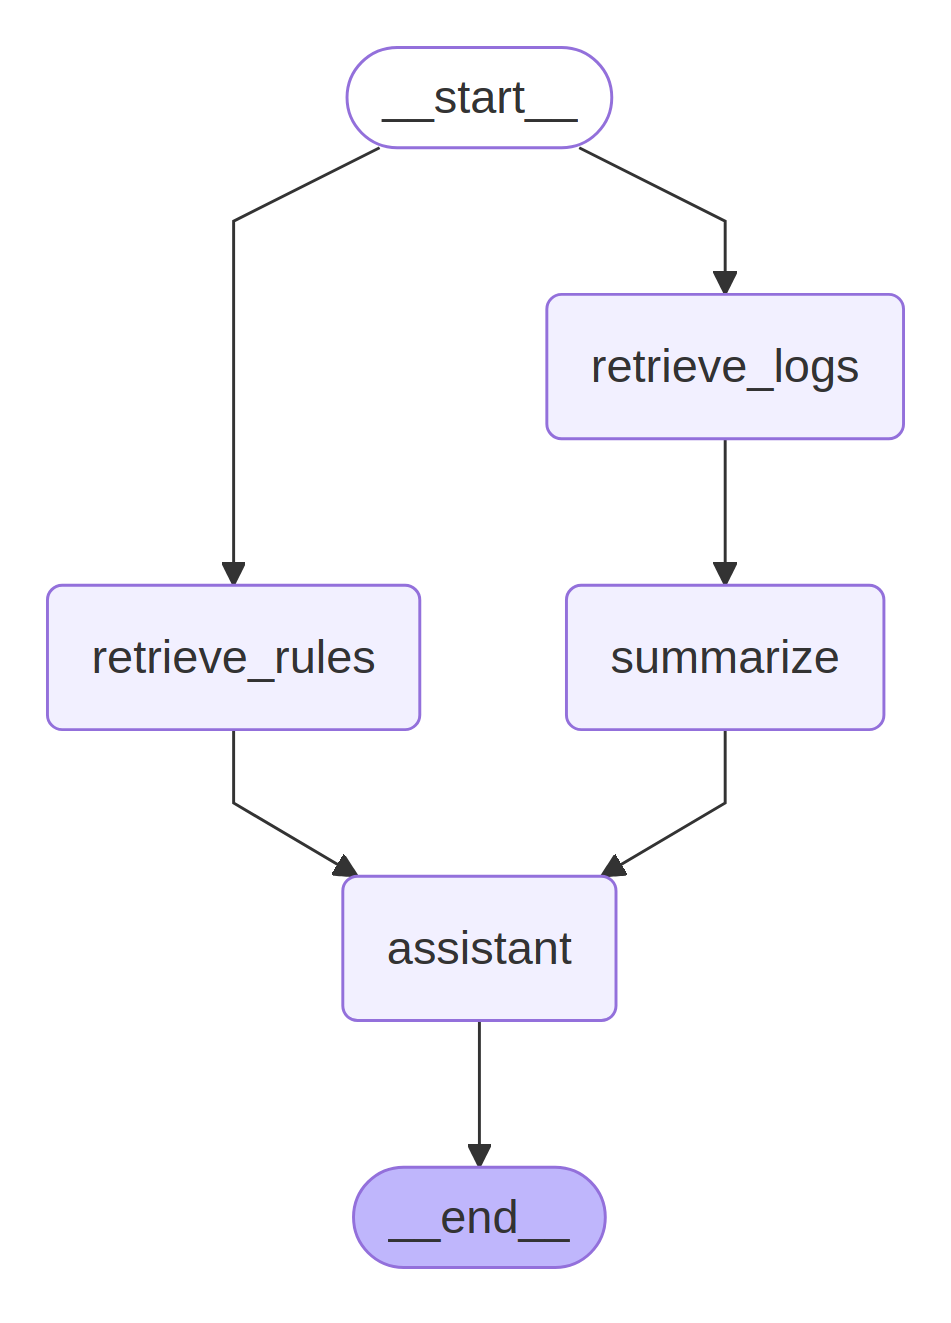

In [52]:
# Graph
builder = StateGraph(HoneypotState)

# Define nodes: 
builder.add_node("assistant", assistant)
builder.add_node("retrieve_rules", retrieve_rules)
builder.add_node("retrieve_logs", retrieve_logs)
builder.add_node("summarize", summarize_logs)

# Define decision points
def should_summarize(state: HoneypotState):
    if len(state.network_logs) % 10 == 0:  # Summarize every 1000 logs
        return "summarize"
    return "assistant"

# Build the graph
builder.add_edge(START, "retrieve_rules")
builder.add_edge(START, "retrieve_logs")

# builder.add_conditional_edges("retrieve_logs", should_summarize, {
#         "summarize": "summarize",
#         "assistant": "assistant"
#     })
builder.add_edge("retrieve_logs", "summarize")
builder.add_edge(["retrieve_rules", "summarize"], "assistant")
builder.add_edge("assistant", END)

graph = builder.compile()

display_graph(graph)

In [53]:
# Create an initial state
initial_state = HoneypotState(
    messages=[],  
    network_logs=[],
    summary="",
    firewall_config=""
)

response = graph.invoke(initial_state)


Network node
Firewall node
Summarizing node
state.messages: []
State summary: [AIMessage(content='Based on the provided network logs and the defined categories, here is a structured summary that highlights the critical patterns observed:\n\n```json\n{\n  "IP_Threat_Indicators": {\n    "High_frequency_sources": {\n      "172.17.0.1": 250,\n      "172.17.0.2": 250\n    },\n    "Known_malicious_IPs": [],\n    "Unverified_new_IPs": {\n      "172.17.0.1": "Apr 22, 2025 10:24:17.094397149 CEST",\n      "172.17.0.2": "Apr 22, 2025 10:24:17.094433299 CEST"\n    }\n  },\n  "Port_Protocol_Risks": {\n    "Suspicious_port_clusters": {\n      "2222:TCP": 250,\n      "Multiple_random_ports:TCP": 250\n    },\n    "Baseline_comparison": "100% traffic matched expected SSH port 2222"\n  },\n  "Geo_Location_Threats": {\n    "Unexpected_regions": [],\n    "ASN_anomalies": []\n  },\n  "Behavioral_Red_Flags": {\n    "Scan_patterns": {\n      "172.17.0.1": "44502-45630:5min",\n      "172.17.0.2": "2222 consi

In [54]:
for m in response['summary']:
    m.pretty_print()

================================== Ai Message ==================================

Based on the provided network logs and the defined categories, here is a structured summary that highlights the critical patterns observed:

```json
{
  "IP_Threat_Indicators": {
    "High_frequency_sources": {
      "172.17.0.1": 250,
      "172.17.0.2": 250
    },
    "Known_malicious_IPs": [],
    "Unverified_new_IPs": {
      "172.17.0.1": "Apr 22, 2025 10:24:17.094397149 CEST",
      "172.17.0.2": "Apr 22, 2025 10:24:17.094433299 CEST"
    }
  },
  "Port_Protocol_Risks": {
    "Suspicious_port_clusters": {
      "2222:TCP": 250,
      "Multiple_random_ports:TCP": 250
    },
    "Baseline_comparison": "100% traffic matched expected SSH port 2222"
  },
  "Geo_Location_Threats": {
    "Unexpected_regions": [],
    "ASN_anomalies": []
  },
  "Behavioral_Red_Flags": {
    "Scan_patterns": {
      "172.17.0.1": "44502-45630:5min",
      "172.17.0.2": "2222 consistently targeted"
    },
    "Protocol_violat

In [55]:
for m in response['messages']:
    m.pretty_print()
    

================================== Ai Message ==================================

```iptables
-A INPUT -s 172.17.0.1 -p tcp --dport 2222 -m conntrack --ctstate NEW -m limit --limit 5/min --limit-burst 10 -j ACCEPT
-A INPUT -s 172.17.0.1 -p tcp --dport 2222 -j DROP
-A INPUT -p tcp --dport 2222 -j ACCEPT
```
